# Where are the objects on the sea floor? Where will they go?

Hazardous objects are unidentified all over the sea floor. What are the spatial patterns that we might see when using machine learning and artificial intelligence to identify such objects? Furthermore, will these objects be buried in sediment or will they move over time? 

In [17]:
import os
import glob
import earthpy as et
import earthpy.plot as ep
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from fiona.drvsupport import supported_drivers
import folium
from folium.plugins import MarkerCluster
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
import zipfile

# python file containing our functions
from kml_functions import read_kml, create_refined_df
from tif_functions import read_tifs, night_lights_tif_to_df, open_tif_to_df

In [18]:
# go to /earth-analytics/data directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

## Generate a boundary for our study area.
### We are focusing on the coastal region of North and South Carolina.
This area was selected by the team due to availability of data on the east coast.
These bounds were selected based on the state lines and the correlated ocean space.


#### Locating objects on the coast of the Carolinas. ####
* This work will map out various objects on the sea floor off the coast of North and South Carolina.
* The state governments keep track of both artificial reefs and oyster sanctuaries. 
* There have also historically been quite a few wrecks in that area which NOAA keeps track of. 
* This notebook will combine all of the mentioned data and map it out on an interactive folium map.

In [19]:
# Create Bounding Box - North and South Carolina coastal region
box = {'geometry': [Polygon([(-77.121369, 36.541466),
                             (-70.760165, 36.541466),
                             (-71.511922, 32.087495),
                             (-79.317663, 31.036502)])]}
bbox_gdf = gpd.GeoDataFrame(box, crs='EPSG:4326')
bbox_gdf.bounds

,minx,miny,maxx,maxy
0,-79.317663,31.036502,-70.760165,36.541466


## Download artifical reef data for the Carolinas

### North Carolina
![NC Reed](img/NC_artificial_reefs.jpg)
Image Credit: North Carolina government, available at [This site](https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs/interactive-reef-guide)
* The North Carolina Division of Marine Fisheries maintains 43 ocean artificial reef and 25 estuarine reefs. These are strategically located and designed to maximize access by anglers and divers, but also serve biological and ecological roles. 
* These reefs are in the inlets as well as off the coast.
* The estuarine reefs include specialized artificials reefs called Pyster Sanctuaries. An oyster sanctuary is an area where the harvest of oyster is prohibited. This encourages the growth of the oyster population. The related reefs are built with materials that encourage baby oysters to settle and grow. These materials are:
 * Natural oyster and clam shell
 * Class B rip-rap marl
 * Reef Balls™
 * Concrete pipes
 * Recycled crushed concrete
 * Various types of mined rock
* There were some challenges with using the `earthpy` package to download this data so there are instructions for that in the `README`. 

### South Carolina
![SC Reef](img/SC_artificial_reefs.jpg)
Image Credit: South Carolina government, available at [This site](https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs/interactive-reef-guide)

* In South Carolina the reefs are managed by the Department of Natural Resources. 
* A lot of funding comes from the Saltwater Recreational Fishing License Program.
* There are over 40 offshore artificial reefs in addition to the inshore reefs.
* Similar to North Carolina fishing and diving are allowed on the reefs. 

Reefs help increase fish populations so there is motivation for state governments, fisherman, and divers to create more. 


In [20]:
# NOTE: Download instructions are in the README for this.
nc_reef_kml_pth = os.path.join(
   et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
   'Reef_Material.kml')

sc_reef_kml_pth = os.path.join(
   et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
   'ArtReef2021__GE', 'ArtReef2021.kml')

if not os.path.exists(sc_reef_kml_pth):
    et.data.get_data(
        url=('https://www.dnr.sc.gov/marine/reef/ArtReef2021__GE.zip'))

## Download ENC and AWOIS wrecks and obstruction data

The Automated Wreck and Obstruction Information System contains information on various obstructions in coastal U.S waters. This database provides us automated information as well as information directly recieved from the electronic nautical charts (ENC's). While the AWOIS tracks a variety of objects, ENC's specifically track shipwrecks. These combined make for comprehensive information on over 13,000 wrecks and 6,000 other obstructions off the coastal United States.

This database contains information on a wide variety of objects, from shipwrecks, to submerged concrete, granite, and more. This information helps provide safe passage through coastal waters and has been pivotal nautical information since it's implementation by the National Ocean Service in 1981. Based on the data within our bounding box, there are staggering 533 ENC Wrecks and 72 AWOIS Obstructions in the region.

![AWOIS](img/AWOIS.png)
Image Credit: NOAA Office of Coast Survery Blog available [here](https://noaacoastsurvey.wordpress.com/tag/noaa-enc/#:~:text=As%20the%20official%20chart%20data,much%20more%20comprehensive%20than%20AWOIS)


In [21]:
# Get datasets from the Wrecks and Obstructions Database
ENC_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'ENC_Wrecks.kml')
AWOIS_wrecks_kml_pth = os.path.join(
    et.io.HOME, 'earth-analytics', 'data', 'earthpy-downloads',
    'AWOIS_Obstructions.kml')

# Caching
if not os.path.exists(ENC_wrecks_kml_pth):
    et.data.get_data(
        url=("https://wrecks.nauticalcharts.noaa.gov/"
             "downloads/ENC_Wrecks.kml"))
if not os.path.exists(AWOIS_wrecks_kml_pth):
    et.data.get_data(
        url="https://wrecks.nauticalcharts.noaa.gov/"
            "downloads/AWOIS_Obstructions.kml")

## Functions for processing the downloaded data.

The `read_kml` function allows us to easiy read in datasets that are KML's and turn them into GeoPandas dataframes. In this process we are also able to clip the data using the bounding box geodataframe we created for the study area (`bbox_gdf`). 

Once we get the geodataframe we want to put our data into a standard Pandas DataFrame with matching headers so that we can combine all our data from various sources that may not initially have all the same headers.  This is what the `create_refined_df` function was built for. It pulls the latitude and longitude from the geometry column of the geodataframe and separates them into their own columns. 

Note: We did create columns for `size` and `description`, but since those are not as uniform to pull they are handled on an individual basis for each data source. Additionally, our geometry method here works best for `POINT` geometry which is why the North Carolina Artificial reef dataset is handled differently since it contains `POLYGON` and `MULTIPOLYGON` geometries.

Text(0.5, 1.0, 'ENC Wrecks')

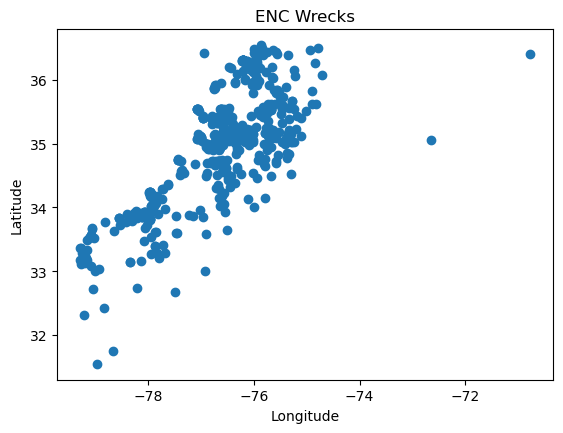

In [22]:
# ENC Wrecks gdf
ENC_gdf = read_kml(ENC_wrecks_kml_pth)
ax = ENC_gdf.plot()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title('ENC Wrecks')

In [23]:
# Convert ENC gdf to refined df
ENC_df = create_refined_df(ENC_gdf)
ENC_df['description'] = 'ENC Wreck'
ENC_df.reset_index()

,index,lat,lon,size,description
0,0,33.922513,-78.068892,NaN,ENC Wreck
1,1,33.891817,-78.059333,NaN,ENC Wreck
2,2,33.912611,-78.013105,NaN,ENC Wreck
3,3,34.248807,-77.972304,NaN,ENC Wreck
4,4,33.854067,-78.110763,NaN,ENC Wreck
...,...,...,...,...,...
528,528,33.138060,-78.346580,NaN,ENC Wreck
529,529,33.405189,-77.712152,NaN,ENC Wreck
530,530,33.393833,-77.878381,NaN,ENC Wreck
531,531,33.283805,-77.831113,NaN,ENC Wreck


Text(0.5, 1.0, 'AWOIS Obstructions')

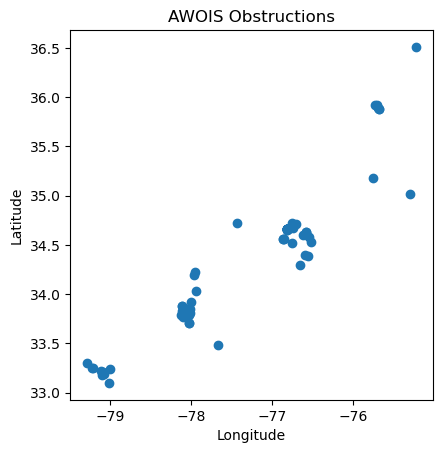

In [24]:
# AWOIS Wrecks/obstrctions gdf
AWOIS_gdf = read_kml(AWOIS_wrecks_kml_pth)

# plot
ax1 = AWOIS_gdf.plot()
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("AWOIS Obstructions")

In [25]:
# AWOIS df
AWOIS_df = create_refined_df(AWOIS_gdf)
AWOIS_df['description'] = 'AWOIS Obstruction'
AWOIS_df

,lat,lon,size,description
0,33.099722,-79.013611,NaN,AWOIS Obstruction
1,33.183092,-79.093350,NaN,AWOIS Obstruction
2,33.196047,-79.090931,NaN,AWOIS Obstruction
3,33.240278,-79.000556,NaN,AWOIS Obstruction
4,34.628000,-76.574953,NaN,AWOIS Obstruction
...,...,...,...,...
67,34.718636,-77.428544,NaN,AWOIS Obstruction
68,36.509286,-75.217386,NaN,AWOIS Obstruction
69,34.298500,-76.651314,NaN,AWOIS Obstruction
70,34.525164,-76.511586,NaN,AWOIS Obstruction


In [26]:
# North Carolina reef material/oyster sanctuaries
# Cannot find file? 
nc_reef_gdf = read_kml(nc_reef_kml_pth)
type(nc_reef_gdf)

type: /home/jovyan/earth-analytics/data/earthpy-downloads/Reef_Material.kml: No such file or directory

In [27]:
# Create North Carolina reef dataframe
nc_reef_df = pd.DataFrame(columns=[
    'lat', 'lon', 'size', 'description'])

nc_reef_df['lon'] = nc_reef_gdf.geometry.centroid.x
nc_reef_df['lat'] = nc_reef_gdf.geometry.centroid.y
nc_reef_df['description'] = nc_reef_gdf.Name
nc_reef_df

type: name 'nc_reef_gdf' is not defined

Text(0.5, 1.0, 'South Carolina Artificial Reefs')

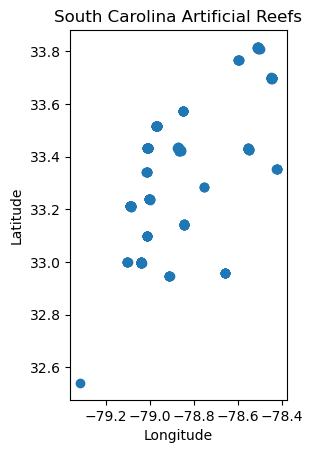

In [28]:
sc_reef_gdf = read_kml(sc_reef_kml_pth)

# plot
ax2 = sc_reef_gdf.plot()
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_title("South Carolina Artificial Reefs")

In [29]:
# South Carolina Reef df
sc_reef_df = create_refined_df(sc_reef_gdf)
sc_reef_df['description'] = sc_reef_gdf.Name
sc_reef_df

,lat,lon,size,description
0,33.426033,-78.865233,NaN,10 Mile APCs
1,33.426067,-78.864950,NaN,10 Mile APCs
2,33.426350,-78.864933,NaN,10 Mile APCs
3,33.426400,-78.865250,NaN,10 Mile APCs
4,33.426550,-78.865783,NaN,10 Mile APCs
...,...,...,...,...
278,33.141667,-78.845267,NaN,W. Upchurch Cones
279,33.141917,-78.845267,NaN,W. Upchurch Cones
280,33.142417,-78.844167,NaN,W. Upchurch Pipe
281,33.516833,-78.970167,NaN,Win Perry


In [30]:
# Concatonate the dataframes
total_df = pd.concat([nc_reef_df, sc_reef_df, AWOIS_df, ENC_df])
total_df

,lat,lon,size,description
0,33.426033,-78.865233,NaN,10 Mile APCs
1,33.426067,-78.864950,NaN,10 Mile APCs
2,33.426350,-78.864933,NaN,10 Mile APCs
3,33.426400,-78.865250,NaN,10 Mile APCs
4,33.426550,-78.865783,NaN,10 Mile APCs
...,...,...,...,...
528,33.138060,-78.346580,NaN,ENC Wreck
529,33.405189,-77.712152,NaN,ENC Wreck
530,33.393833,-77.878381,NaN,ENC Wreck
531,33.283805,-77.831113,NaN,ENC Wreck


## Interactive Map
Using Folium we were able to create an interactive map using markers. These markers use the latitude and longitude from the dataframe for their locations and their description shows when you click on a marker. These markers cluster together into bigger spots to create hot spots of discarded objects as you zoom out.

In [31]:
# Map our concatonated dataframe
m = folium.Map(location=[32.087495, -71.511922], zoom_start=6)

marker_cluster = MarkerCluster().add_to(m)

for index, row in total_df.iterrows():
    folium.Marker(
        location=[row.lat, row.lon],
        popup=row.description,
        icon=folium.Icon(color="black")
    ).add_to(marker_cluster)

m

## What's Next?

Now that we have successfully identified our region of interest and downloaded multiple data sources, we will begin pahse II of our project. This step is to analyze these objects and identify what may happen to them. We will take into account the sediment type on the ocean floor, currents, depth, the density of the object and more to discern this. Machine learning - likely random forest- will help us acheive this. We will ultimately end up with a raster map that forecasts the fate of these objects over time.

In [32]:
# Night Lights Data
# unzip

os.chdir(os.path.join(
   et.io.HOME, 'seafloor-objects'))

night_lights_tif_path = os.path.join('data','night-lights', '*.tif')

night_lights_files = glob.glob(
    os.path.join('data','night-lights','*.zip'))

if not os.path.exists(night_lights_tif_path):      
    for file in night_lights_files:
        print('Unzipping:',file)

        with zipfile.ZipFile(file, 'r') as zip_ref:
            zip_ref.extractall('data/night-lights')
        
night_lights_tifs =  [f for f in glob.glob(
    os.path.join('data','night-lights','*.tif'))]

print(night_lights_tifs)

Unzipping: data/night-lights/VBD_npp_20180101-20181231_usa-e_v23.zip
Unzipping: data/night-lights/VBD_npp_20190101-20191231_usa-e_v23.zip
Unzipping: data/night-lights/VBD_npp_20200101-20201231_usa-e_v23.zip
['data/night-lights/VBD_npp_20200101-20201231_usa-e_pc_v23_c202103291200.cvg.tif', 'data/night-lights/VBD_npp_20190101-20191231_usa-e_qf1-2-3-8-10-pc_v23_c202006191500.n_detect.tif', 'data/night-lights/VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.n_detect.tif', 'data/night-lights/VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c202103291200.avg_rade9.tif', 'data/night-lights/VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c202103291200.n_detect.tif', 'data/night-lights/VBD_npp_20190101-20191231_usa-e_pc_v23_c202006191500.cvg.tif', 'data/night-lights/VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.avg_rade9.tif', 'data/night-lights/VBD_npp_20200101-20201231_usa-e_qf1-2-3-8-10-pc_v23_c202103291200.pct_detect.tif', 'data/night-lights/VBD_n

In [33]:
read_tifs(night_lights_tifs[2])

The crs of your data is: EPSG:4326
The nodatavalue of your data is: None
The shape of your data is: (1, 4561, 3841)
The spatial resolution for your data is: (0.0041666667, -0.0041666667)
The metadata for your data is: {'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2019:02:22 12:00:33', 'TIFFTAG_DOCUMENTNAME': './VBD_npp_20180101-20181231_usa-e_qf1-2-3-8-10-pc_v23_c201902201100.n_detect.tif', 'TIFFTAG_IMAGEDESCRIPTION': 'IDL TIFF file', 'TIFFTAG_RESOLUTIONUNIT': '2 (pixels/inch)', 'TIFFTAG_SOFTWARE': 'IDL 8.5.1, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.', 'TIFFTAG_XRESOLUTION': 100, 'TIFFTAG_YRESOLUTION': 100, 'scale_factor': 1.0, 'add_offset': 0.0}


In [34]:
night_lights_0 = night_lights_tif_to_df(night_lights_tifs[0], 'night lights 0')
night_lights_1 = night_lights_tif_to_df(night_lights_tifs[1], 'night lights 1')
night_lights_2 = night_lights_tif_to_df(night_lights_tifs[2], 'night lights 2')
night_lights_3 = night_lights_tif_to_df(night_lights_tifs[3], 'night lights 3')
night_lights_4 = night_lights_tif_to_df(night_lights_tifs[4], 'night lights 4')
night_lights_5 = night_lights_tif_to_df(night_lights_tifs[5], 'night lights 5')
night_lights_6 = night_lights_tif_to_df(night_lights_tifs[6], 'night lights 6')
night_lights_7 = night_lights_tif_to_df(night_lights_tifs[7], 'night lights 7')
night_lights_8 = night_lights_tif_to_df(night_lights_tifs[8], 'night lights 8')
night_lights_9 = night_lights_tif_to_df(night_lights_tifs[9], 'night lights 9')
night_lights_10 = night_lights_tif_to_df(night_lights_tifs[10], 'night lights 10')
night_lights_11 = night_lights_tif_to_df(night_lights_tifs[11], 'night lights 11')
# Concatonate night lights dataframes
night_lights_total_df = pd.concat([night_lights_11, night_lights_10, night_lights_9, night_lights_8, night_lights_7, night_lights_6, night_lights_5, night_lights_4, night_lights_3, night_lights_2, night_lights_1, night_lights_0])
night_lights_total_df

band  spatial_ref  night lights 11  night lights 10  \
y    x                                                                 
49.5 -81.500000     1            0            134.0              NaN   
     -81.495833     1            0            115.0              NaN   
     -81.491667     1            0            137.0              NaN   
     -81.487500     1            0            133.0              NaN   
     -81.483333     1            0            121.0              NaN   
...               ...          ...              ...              ...   
30.5 -65.516667     1            0              NaN              NaN   
     -65.512500     1            0              NaN              NaN   
     -65.508333     1            0              NaN              NaN   
     -65.504167     1            0              NaN              NaN   
     -65.500000     1            0              NaN              NaN   

                 night lights 9  night lights 8  night lights 7  \
y    x                                                            
49.5 -81.500000             NaN             NaN             NaN   
     -81.495833             NaN             NaN             NaN   
     -81.491667             NaN             NaN             NaN   
     -81.487500             NaN             NaN             NaN   
     -81.483333             NaN             NaN             NaN   
...                         ...             ...             ...   
30.5 -65.516667             NaN             NaN             NaN   
     -65.512500             NaN             NaN             NaN   
     -65.508333             NaN             NaN             NaN   
     -65.504167             NaN             NaN             NaN   
     -65.500000             NaN             NaN             NaN   

                 night lights 6  night lights 5  night lights 4  \
y    x                                                            
49.5 -81.500000             NaN             NaN             NaN   
     -81.495833             NaN             NaN             NaN   
     -81.491667             NaN             NaN             NaN   
     -81.487500             NaN             NaN             NaN   
     -81.483333             NaN             NaN             NaN   
...                         ...             ...             ...   
30.5 -65.516667             NaN             NaN             NaN   
     -65.512500             NaN             NaN             NaN   
     -65.508333             NaN             NaN             NaN   
     -65.504167             NaN             NaN             NaN   
     -65.500000             NaN             NaN             NaN   

                 night lights 3  night lights 2  night lights 1  \
y    x                                                            
49.5 -81.500000             NaN             NaN             NaN   
     -81.495833             NaN             NaN             NaN   
     -81.491667             NaN             NaN             NaN   
     -81.487500             NaN             NaN             NaN   
     -81.483333             NaN             NaN             NaN   
...                         ...             ...             ...   
30.5 -65.516667             NaN             NaN             NaN   
     -65.512500             NaN             NaN             NaN   
     -65.508333             NaN             NaN             NaN   
     -65.504167             NaN             NaN             NaN   
     -65.500000             NaN             NaN             NaN   

                 night lights 0  
y    x                           
49.5 -81.500000             NaN  
     -81.495833             NaN  
     -81.491667             NaN  
     -81.487500             NaN  
     -81.483333             NaN  
...                         ...  
30.5 -65.516667           160.0  
     -65.512500           159.0  
     -65.508333           165.0  
     -65.504167           162.0  
     -65.500000           159.0  

[52828241 rows x 14 c

In [35]:
# I uploaded our ASC's to QGIS and exported it as a geotiff there. Then I used the method we already had formulated for geotiffs. 
# Training data TIF's

bathymetry_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'bathymetry', 'bathymetry1.tif')
bathymetry_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'bathymetry','bathymetry2.tif')
marine_mishaps_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'marine_mishaps', 'marine_mishaps1.tif')
marine_mishaps_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'marine_mishaps', 'marine_mishaps_coast.tif')
state_boating_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'state_boating', 'state_boating_opensea.tif')
state_boating_coast_path = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'state_boating', 'state_boating_rampsoncoast.tif')

# Open TIF and read it in array
bathymetry = rxr.open_rasterio(bathymetry_path, masked=True)
bathymetry2 = rxr.open_rasterio(bathymetry_path_2, masked=True)
bathymetry2.rio.bounds()

state_boating_opensea = rxr.open_rasterio(state_boating_path, masked=True)
state_boating_rampsoncoast = rxr.open_rasterio(state_boating_path, masked=True)
state_boating_rampsoncoast.rio.bounds()

marine_mishaps_coast = rxr.open_rasterio(marine_mishaps_path_2, masked=True)
marine_mishaps = rxr.open_rasterio(marine_mishaps_path, masked=True)
marine_mishaps.rio.bounds()

(0.0, 0.0, 645.0, 454.0)

In [36]:
read_tifs(bathymetry_path_2)

The crs of your data is: None
The nodatavalue of your data is: nan
The shape of your data is: (1, 91, 129)
The spatial resolution for your data is: (0.050000000000000024, -0.04999999999999997)
The metadata for your data is: {'STATISTICS_MAXIMUM': 8.31, 'STATISTICS_MEAN': 5.509498086547, 'STATISTICS_MINIMUM': 1.97, 'STATISTICS_STDDEV': 1.3390008966787, 'STATISTICS_VALID_PERCENT': 57.88, 'scale_factor': 1.0, 'add_offset': 0.0}


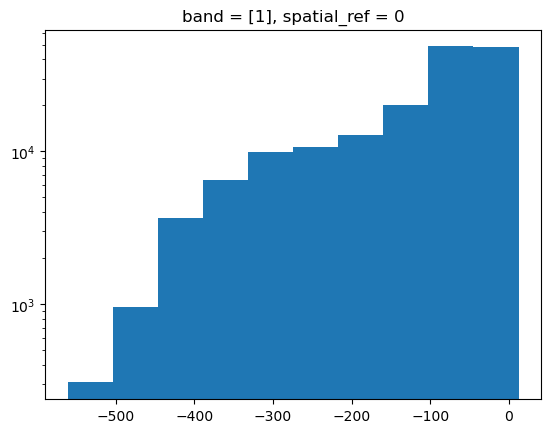

the minimum raster value is:  <xarray.DataArray ()>
array(-2.69916914)
Coordinates:
    spatial_ref  int64 0
the maximum raster value is:  <xarray.DataArray ()>
array(167.96897916)
Coordinates:
    spatial_ref  int64 0


In [37]:
# Plot using earthpy
marine_mishaps.plot.hist(yscale="log")
plt.show()
print("the minimum raster value is: ", state_boating_opensea.min())
print("the maximum raster value is: ", state_boating_opensea.max())

In [38]:
bathyemtry1_df = open_tif_to_df(bathymetry, "bathymetry")

In [39]:
bathyemtry2_df = open_tif_to_df(bathymetry2, "bathymetry2")

In [40]:
state_boating_rampsoncoast_df = open_tif_to_df(state_boating_rampsoncoast, "state_boating_rampsoncoast")

In [41]:
state_boating_opensea_df = open_tif_to_df(state_boating_opensea, "state_boating_opensea")


In [42]:
marine_mishaps_coast_df = open_tif_to_df(marine_mishaps_coast, "marine_mishaps_coast")

In [43]:
marine_mishaps_df = open_tif_to_df(marine_mishaps, "marine_mishaps")

In [ ]:
# continue concatonation 
all_tif_source_dfs = pd.concat([
    marine_mishaps_df,
    marine_mishaps_coast_df,
    state_boating_opensea_df,
    state_boating_rampsoncoast_df,
    night_lights_total_df, 
    bathyemtry2_df,
    bathyemtry1_df
])
all_tif_source_dfs

In [32]:
# We will likely throw this out

training_data_path = os.path.join(et.io.HOME,'seafloor-objects', 
                                  'data', 'trainingData.csv')
if os.path.exists(training_data_path):
    print('yes')
    
training_data_df = pd.read_csv(training_data_path)

print(training_data_df)

yes
      i    j  artificialReefs  awoisWrecks  awoisObstructions  wrecksEnc  \
0     0  101              NaN          4.0                NaN        2.0   
1     0  102              NaN          2.0                NaN        NaN   
2     1   98              NaN          NaN                NaN        1.0   
3     1  102              NaN          1.0                NaN        1.0   
4     1  106              NaN          NaN                NaN        1.0   
..   ..  ...              ...          ...                ...        ...   
622  90    7             15.0          NaN                1.0        NaN   
623  90    8             21.0          NaN                NaN        1.0   
624  90    9              NaN          NaN                1.0        NaN   
625  90   10             21.0          NaN                1.0        NaN   
626  90   94              NaN          1.0                NaN        NaN   

     elevations  waveHeights    viirsA  smallBoatTraffic  aisTrafficDensity  
0    

In [44]:
# Prediction data TIFs

# Would like to open these with a for loop or glob?

cw_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'currents_and_waves', 'currents_and_waves2.tif')
cw_path_3 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'currents_and_waves', 'currents_and_waves3.tif')
cw_path_4 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'currents_and_waves', 'currents_and_waves4.tif')
cw_path_5 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'currents_and_waves', 'currents_and_waves5.tif')

db_path_1 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials1.tif')
db_path_2 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials2.tif')
db_path_3 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials3.tif')
db_path_4 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials4.tif')
db_path_5 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials5.tif')
db_path_6 = os.path.join(et.io.HOME, 'seafloor-objects', 'data', 'dbseabed_materials', 'dbseabed_materials6.tif')

# Use a for loop to create paths if they do not exist
for path in [cw_path_2, cw_path_3, cw_path_4, cw_path_5, db_path_1, db_path_2, db_path_3, db_path_4, db_path_5, db_path_6]:
    if not os.path.exists(path): 
        print(
            'Path {} does not exist. Creating, please hold...'
            .format(path))
        os.makedirs(path)
    else:
            print('{} DOES exist!'.format(path))

/home/jovyan/seafloor-objects/data/currents_and_waves/currents_and_waves2.tif DOES exist!
/home/jovyan/seafloor-objects/data/currents_and_waves/currents_and_waves3.tif DOES exist!
/home/jovyan/seafloor-objects/data/currents_and_waves/currents_and_waves4.tif DOES exist!
/home/jovyan/seafloor-objects/data/currents_and_waves/currents_and_waves5.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials1.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials2.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials3.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials4.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials5.tif DOES exist!
/home/jovyan/seafloor-objects/data/dbseabed_materials/dbseabed_materials6.tif DOES exist!


In [45]:
# Is this step unncessary?

def open_to_rasterio(path, masked=True):
    """
    Open our Tif with rasterio
    """
    array = rxr.open_rasterio(path, masked=True)
    return array

db_1 = open_to_rasterio(db_path_1, masked=True)
db_2 = open_to_rasterio(db_path_2, masked=True)
db_3 = open_to_rasterio(db_path_3, masked=True)
db_4 = open_to_rasterio(db_path_4, masked=True)
db_5 = open_to_rasterio(db_path_5, masked=True)
db_6 = open_to_rasterio(db_path_6, masked=True)
cw_2 = open_to_rasterio(cw_path_2, masked=True)
cw_3 = open_to_rasterio(cw_path_3, masked=True)
cw_4 = open_to_rasterio(cw_path_4, masked=True)
cw_5 = open_to_rasterio(cw_path_5, masked=True)


In [46]:
db_1_df = open_tif_to_df(db_1, "dbseabed_materials1.tif")
db_1_df.reset_index()

,band,y,x,spatial_ref,dbseabed_materials1.tif
0,1,36.545,-76.125,0,7.6
1,1,36.545,-76.025,0,10.4
2,1,36.545,-75.975,0,8.1
3,1,36.545,-75.875,0,1.5
4,1,36.545,-75.825,0,26.2
...,...,...,...,...,...
6469,1,32.045,-74.725,0,13.2
6470,1,32.045,-74.675,0,11.6
6471,1,32.045,-74.625,0,7.4
6472,1,32.045,-74.575,0,7.4


In [47]:
db_2_df = open_tif_to_df(db_2, "dbseabed_materials2.tif")
db_2_df

spatial_ref  dbseabed_materials2.tif
band y      x                                            
1    36.545 -76.125            0                     15.0
            -76.025            0                     36.1
            -75.975            0                     14.8
            -75.875            0                      1.5
            -75.825            0                      6.1
...                          ...                      ...
     32.045 -74.725            0                     48.7
            -74.675            0                     45.9
            -74.625            0                     54.3
            -74.575            0                     52.7
            -74.525            0                     31.0

[6474 rows x 2 columns]

In [48]:
db_3_df = open_tif_to_df(db_3, "dbseabed_materials3.tif")
db_3_df

spatial_ref  dbseabed_materials3.tif
band y      x                                            
1    36.545 -76.125            0                     80.3
            -76.025            0                     56.4
            -75.975            0                     80.0
            -75.875            0                    100.0
            -75.825            0                     70.7
...                          ...                      ...
     32.045 -74.725            0                     41.0
            -74.675            0                     45.5
            -74.625            0                     41.2
            -74.575            0                     42.9
            -74.525            0                     59.3

[6474 rows x 2 columns]

In [49]:
db_4_df = open_tif_to_df(db_4, "dbseabed_materials4.tif")
db_4_df

spatial_ref  dbseabed_materials4.tif
band y      x                                            
1    36.545 -76.125            0                     1.68
            -76.025            0                     2.46
            -75.975            0                     1.63
            -75.875            0                     1.20
            -75.825            0                     0.30
...                          ...                      ...
     32.045 -74.725            0                     3.22
            -74.675            0                     3.05
            -74.625            0                     3.31
            -74.575            0                     3.24
            -74.525            0                     2.25

[6442 rows x 2 columns]

In [50]:
db_5_df = open_tif_to_df(db_5, "dbseabed_materials5.tif")
db_5_df

spatial_ref  dbseabed_materials5.tif
band y      x                                            
1    36.545 -76.125            0                      0.0
            -76.025            0                      0.0
            -75.975            0                      0.0
            -75.875            0                      0.0
            -75.825            0                      0.0
...                          ...                      ...
     32.045 -74.725            0                      0.0
            -74.675            0                      0.0
            -74.625            0                      0.0
            -74.575            0                      0.0
            -74.525            0                      0.0

[6455 rows x 2 columns]

In [51]:
db_6_df = open_tif_to_df(db_6, "dbseabed_materials6.tif")
db_6_df

spatial_ref  dbseabed_materials6.tif
band y      x                                            
1    36.545 -76.125            0                     1.79
            -76.025            0                     0.78
            -75.975            0                     1.82
            -75.875            0                     0.70
            -75.825            0                     1.60
...                          ...                      ...
     32.045 -74.725            0                     0.76
            -74.675            0                     0.80
            -74.625            0                     0.73
            -74.575            0                     0.73
            -74.525            0                     0.86

[6439 rows x 2 columns]

In [52]:
cw_2_df = open_tif_to_df(cw_2, "currents_and_waves2.tif")
cw_2_df.reset_index()

,band,y,x,spatial_ref,currents_and_waves2.tif
0,1,36.545,-76.125,0,0.01
1,1,36.545,-76.075,0,0.01
2,1,36.545,-76.025,0,0.01
3,1,36.545,-75.975,0,0.01
4,1,36.545,-75.925,0,0.01
...,...,...,...,...,...
6789,1,32.045,-74.725,0,0.07
6790,1,32.045,-74.675,0,0.12
6791,1,32.045,-74.625,0,0.12
6792,1,32.045,-74.575,0,0.15


In [53]:
cw_3_df = open_tif_to_df(cw_3, "currents_and_waves3.tif")
cw_3_df.reset_index()

,band,y,x,spatial_ref,currents_and_waves3.tif
0,1,36.545,-76.125,0,-0.01
1,1,36.545,-76.075,0,-0.01
2,1,36.545,-76.025,0,-0.01
3,1,36.545,-75.975,0,-0.01
4,1,36.545,-75.925,0,-0.01
...,...,...,...,...,...
6789,1,32.045,-74.725,0,-0.01
6790,1,32.045,-74.675,0,-0.02
6791,1,32.045,-74.625,0,-0.02
6792,1,32.045,-74.575,0,-0.01


In [54]:
cw_4_df = open_tif_to_df(cw_4, "currents_and_waves4.tif")
cw_4_df.reset_index()

,band,y,x,spatial_ref,currents_and_waves4.tif
0,1,36.545,-76.125,0,0.01
1,1,36.545,-76.075,0,0.01
2,1,36.545,-76.025,0,0.01
3,1,36.545,-75.975,0,0.01
4,1,36.545,-75.925,0,0.01
...,...,...,...,...,...
6789,1,32.045,-74.725,0,-0.06
6790,1,32.045,-74.675,0,-0.12
6791,1,32.045,-74.625,0,-0.12
6792,1,32.045,-74.575,0,-0.15


In [58]:
cw_5_df = open_tif_to_df(cw_5, "currents_and_waves5.tif")

cw_5_df.reset_index()
#cw_5_df.reset_index(level=[1])

,band,y,x,spatial_ref,currents_and_waves5.tif
0,1,36.545,-76.025,0,0.00
1,1,36.545,-75.825,0,0.63
2,1,36.545,-75.775,0,0.57
3,1,36.545,-75.725,0,0.63
4,1,36.545,-75.675,0,0.75
...,...,...,...,...,...
6240,1,32.045,-74.725,0,0.00
6241,1,32.045,-74.675,0,0.00
6242,1,32.045,-74.625,0,0.00
6243,1,32.045,-74.575,0,0.00


In [ ]:
# Prediction Data

# I cannot figure out how to get all of these together. My kernel constantly d. Docker is using all my RAM and needs more to combine these data sets.

#prediction_tifs_df = pd.concat([
 #   cw_2_df, cw_3_df, cw_4_df, cw_5_df,
  #  db_1_df, db_2_df, db_3_df, db_4_df, 
   # db_5_df, db_6_df
#])

#prediction_tifs_df

#prediction_df = pd.merge(cw_2_df, cw_3_df, cw_4_df, cw_5_df, db_1_df, db_2_df, db_3_df, db_4_df, db_5_df, db_6_df, how = 'left')

prediction_df = pd.merge(cw_2_df, cw_3_df, on='spatial_ref', how='left')

#prediction_df = cw_2_df.merge(cw_3_df, on='spatial_ref').merge(cw_4_df, on='spatial_ref').merge(cw_5_df, on='spatial_ref')
prediction_df

#prediction_df_2 = pd.merge(prediction_df, cw_4_df)

In [22]:
prediction_df2 = cw_2_df.join([cw_3_df, cw_4_df, cw_5_df, db_1_df, db_2_df, db_3_df, db_4_df, db_5_df, db_6_df], how = 'left')
prediction_df2

type: Indexes have overlapping values: Index(['spatial_ref'], dtype='object')

### Citations:

Byrum, J., & Hendrix, N. (n.d.). Artificial Reefs. North Carolina Environmental Quality. Retrieved April 18, 2023, from https://www.deq.nc.gov/about/divisions/marine-fisheries/public-information-and-education/coastal-fishing-information/artificial-reefs

Coz, J. (n.d.). Artificial Reefs - Data Files. Retrieved April 29, 2023, from https://www.dnr.sc.gov/marine/reef/

National Oceanic and Atmospheric Administration (n.d.). Wrecks and Obstructions Database. U.S. Office of Coast Survey. Retrieved April 21, 2023, from https://nauticalcharts.noaa.gov/data/wrecks-and-obstructions.html



In [32]:
# Nearest neighbors helpful stuff
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors